# Spectral Sampling Demonstration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summit.utils.models import GPyModel
import matplotlib.pyplot as plt
import numpy as np

In [54]:
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05
m = GPyModel(input_dim=1)

In [55]:
%timeit m.fit(X, Y)

288 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
def fit_and_sample():
    X = np.random.uniform(-3.,3.,(20,1))
    Y = np.sin(X) + np.random.randn(20,1)*0.05
    m = GPyModel(input_dim=1)
    m.fit(X, Y)
    sampled_f = m.spectral_sample(X, Y)
    predict_Y = m.predict(X)
    sample_Y = sampled_f(X)
    return X, Y, predict_Y, sample_Y

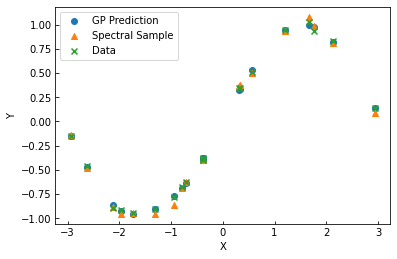

In [52]:
X, Y, predict_Y, sample_Y = fit_and_sample()
fig, ax = plt.subplots(1)
ax.scatter(X[:,0], predict_Y[:, 0], marker= 'o', label='GP Prediction')
ax.scatter(X[:,0], sample_Y[:,0], marker='^', label= 'Spectral Sample')
ax.scatter(X[:,0], Y[:, 0], marker='x', label='Data')
ax.legend()
ax.tick_params(direction='in')
ax.set_xlabel('X')
_ = ax.set_ylabel('Y')

In [53]:
mae_pred = np.mean(np.abs(predict_Y[:,0]-Y[:,0]))
mae_sample = np.mean(np.abs(sample_Y[:,0]-Y[:,0]))
print("MAE GP: ", mae_pred)
print("MAE Spectral Sample: ", mae_sample)

MAE GP:  0.012582393439350009
MAE Spectral Sample:  0.027726602185563044


Comparing time for spectral sampling vs. calling the model directly.

In [66]:
def timed_fit_and_predict(use_spectral_sample=False):
    X = np.random.uniform(-3.,3.,(20,1))
    Y = np.sin(X) + np.random.randn(20,1)*0.05
    m = GPyModel(input_dim=1)
    m.fit(X, Y, spectral_sample=use_spectral_sample)
    for i in range(1000):
        m.predict(X, use_spectral_sample=use_spectral_sample)

In [6]:
%timeit timed_fit_and_predict(use_spectral_sample=False)

660 ms ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit timed_fit_and_predict(use_spectral_sample=True)

8.79 s ± 468 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1]:
import numpy as np
from numpy import matlib
from numpy.random import default_rng
from GPy.models import GPRegression
from GPy.kern import Matern52
from scipy.stats import norm, invgamma
from scipy.stats.distributions import chi2
from scipy import linalg
from summit.utils.lhs import lhs
from numba import jit

In [13]:
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

In [67]:
def create_and_train_model(X, Y):
    m = GPyModel(input_dim=1)
    m.fit(X, Y, spectral_sample=False)
    return m

In [8]:
%timeit create_and_train_model(X, Y)

393 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
m = create_and_train_model(X, Y)

In [11]:
def calculate_phi_b_W(m, X):
    matern_nu = 5
    n_spectral_points = 4000

    # Get variables from problem structure
    n, D = np.shape(X)
    ell = np.array(m._model.kern.lengthscale) 
    sf2 = np.array(m._model.kern.variance)
    sn2 = np.array(m._model.Gaussian_noise.variance)

    # Monte carlo samples of W and b
    # W = p*norminv(sW1)*q
    sW = lhs(D, n_spectral_points)
    p = matlib.repmat(np.divide(1, ell), n_spectral_points, 1)
    if matern_nu != np.inf:            
        inv = chi2.ppf(sW, matern_nu)
        q = np.sqrt(np.divide(matern_nu, inv))
        W = np.multiply(p, norm.ppf(sW))
        W = np.multiply(W, q)
    else:
        raise NotImplementedError("RBF not implemented yet!")

    b = 2*np.pi*lhs(1, n_spectral_points)

    # Calculate phi
    phi = np.sqrt(2*sf2/n_spectral_points)*np.cos(W@X.T +  matlib.repmat(b, 1, n))
    phi = np.round(phi, 3) # Round due to truncation errors that causes problems with inverse
    return W, b, phi

In [33]:
%timeit calculate_phi_b_W(m)

9.85 ms ± 517 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
W, b, phi = calculate_phi_b_W(m, X)

In [73]:
def calc_mean_cov_svd(sn2, n_spectral_points, phi):
    A = phi@phi.T + sn2*np.identity(n_spectral_points)
    u,s, vh = np.linalg.svd(A)
    invA = vh*.u.T
#     invA = np.dot(c.T,c)
#     mu_theta = invA@phi@Y
#     cov_theta = sn2*invA
#     cov_theta = 0.5*(cov_theta+cov_theta.T)
#     return mu_theta, cov_theta
    return invA

In [44]:
@jit(nopython=True, fastmath=True)
def calc_mean_cov(sn2, n_spectral_points, phi):
    A = phi@phi.T + sn2*np.identity(n_spectral_points)
    B = np.linalg.cholesky(A)
    c = np.linalg.inv(B)
    invA = np.dot(c.T,c)
    mu_theta = invA@phi@Y
    cov_theta = sn2*invA
    cov_theta = 0.5*(cov_theta+cov_theta.T)
    return mu_theta, cov_theta

In [48]:
def inv_cholesky(A):
    _, n = np.shape(A)
    chol = np.linalg.cholesky(A)
    x = np.linalg.solve(chol.transpose(), np.identity(n))
    y = np.linalg.solve(chol, x)
    return y

In [49]:
@jit(nopython=True, fastmath=True)
def inv_cholesky_jit(A):
    _, n = np.shape(A)
    chol = np.linalg.cholesky(A)
    x = np.linalg.solve(chol.transpose(), np.identity(n))
    y = np.linalg.solve(chol, x)
    return y

In [49]:
@jit(nopython=True, fastmath=True)
def inv_cholesky_scipy(A):
    _, n = np.shape(A)
    chol = np.linalg.cholesky(A)
    x = scipy.linalg.solve(chol.transpose(), np.identity(n))
    y = scipy.linalg.solve(chol, x)
    return y

In [38]:
sn2 = np.array(m._model.Gaussian_noise.variance)
n_spectral_points = 4000

In [45]:
%timeit calc_mean_cov(sn2, n_spectral_points, phi)

7.72 s ± 1.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
A = phi@phi.T + sn2*np.identity(n_spectral_points)

In [76]:
u,s, vh = np.linalg.svd(A)

In [82]:
invA = vh.T@np.diag(1/s)@u.T

In [80]:
B = np.linalg.cholesky(A)
c = np.linalg.inv(B)
invA_chol = np.dot(c.T,c)

In [83]:
np.isclose(invA, invA_chol)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
%timeit np.linalg.inv(np.linalg.cholesky(A))

In [47]:
%timeit inv_cholesky(A)

7.91 s ± 710 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%timeit inv_cholesky_jit(A)

7.97 s ± 742 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
mu_theta, cov_theta = calc_mean_cov(sn2, n_spectral_points, phi)

In [31]:
def random_calc():
    rng = default_rng()
    theta = rng.multivariate_normal(mu_theta[:, 0], cov_theta,
                                    method='cholesky')

In [32]:
%timeit random_calc()

753 ms ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#Posterior sample according to theta
def f(x):
    if isinstance(x, np.ndarray):
        x =  (x-self.input_mean)/self.input_std
        x[abs(x) < 1e-5] = 0.0
    elif isinstance(X, DataSet):
        x = x.standardize(mean=self.input_mean, 
                          std=self.input_std)
    inputs, _ = np.shape(x)
    bprime = matlib.repmat(b, 1, inputs)
    output =  (theta.T*np.sqrt(2*sf2/n_spectral_points))@np.cos(W@x.T+bprime)
    return np.atleast_2d(output).T